In [9]:
import gymnasium as gym
import torch, torch.nn as nn, torch.nn.functional as F, torch.distributions as distrib
import matplotlib.pyplot as plt
import collections, typing
from tqdm import trange

In [4]:
env = gym.make("Taxi-v3")

In [5]:
action_tab = nn.Embedding(500, 6) # mapping: observation -> action
params_init = next(iter(action_tab.parameters())).clone()
logs = collections.defaultdict(list)

In [10]:
def run_episode():
  states, actions, rewards = [], [], []
  state, _ = env.reset()
  while True:
    states.append(state)
    action_logits = action_tab(torch.as_tensor(state))
    action = distrib.Categorical(logits=action_logits).sample()
    state, reward, done, trunc, _ = env.step(action.item())
    actions.append(action)
    rewards.append(reward)
    if done or trunc:
      break
  return states, actions, rewards

In [11]:
for step in (pbar := trange(10000)):
  # record episodes
  states, actions, rewards = run_episode()

  # compute episode's reward
  eprew = sum(rewards)
  
  # compute expected reward
  logits = action_tab(torch.as_tensor(states))
  logliks = F.log_softmax(logits, dim=-1)[torch.arange(len(states)), torch.as_tensor(actions)]
  expected_reward = eprew * torch.sum(logliks)

  # clear gradients
  for p in action_tab.parameters():
    p.grad = None
  # compute backward pass to fill out p.grad for all parameters p
  expected_reward.backward()
  # run gradient ascent step
  lr = 1e-3
  for p in action_tab.parameters():
    p.data += lr * p.grad
    
  probas = F.softmax(next(iter(action_tab.parameters())), dim=-1)
  entropies = -(probas * probas.log()).sum(-1)
  model_entropy = entropies.mean()
  pbar.set_description(f"expected_reward={expected_reward.item():10.2f}, average_model_entropy={model_entropy.item():.03f}")
  logs["expected_reward"].append(expected_reward.item())
  logs["average_model_entropy"].append(model_entropy.item())

expected_reward=   -118.55, average_model_entropy=0.600: 100%|██████████| 10000/10000 [04:51<00:00, 34.26it/s]


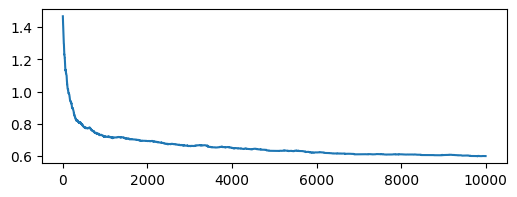

In [12]:
plt.figure(figsize=(6,2))
plt.plot(logs["average_model_entropy"]);

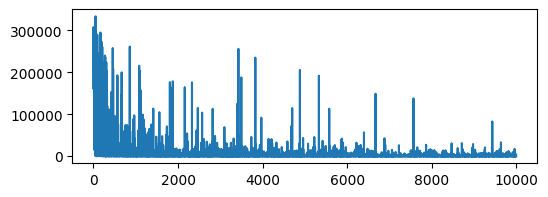

In [13]:
plt.figure(figsize=(6,2))
plt.plot(logs["expected_reward"]);

In [14]:
F.softmax(action_tab(torch.tensor([64, 44])), dim=-1)

tensor([[5.7042e-04, 9.9482e-01, 1.4594e-03, 1.3450e-03, 8.1281e-04, 9.9241e-04],
        [9.1728e-01, 1.4930e-02, 5.3197e-03, 2.1999e-03, 5.6642e-02, 3.6248e-03]],
       grad_fn=<SoftmaxBackward0>)

In [16]:
params_init[torch.tensor([64, 44])]

tensor([[-1.2885, -0.6707, -0.6176, -0.1061, -1.5016, -1.7277],
        [-1.0065,  2.6198,  0.4094, -0.4798, -0.6338, -0.8029]],
       grad_fn=<IndexBackward0>)